In [3]:
import boto3
import subprocess
import json
import os
import time
import re
import random
import pandas as pd
from datetime import datetime, timezone, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

import sys
sys.path.append('..')
from awsutils import *

/var/folders/sb/ph4rxk6j27v6qfqt_n53_bzm0000gq/T/ipykernel_64122/1058715622.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [18]:
from aws_sso_lib.sso import list_available_accounts, list_available_roles

# create a dictionary of account names and account ids
accounts = {account_name: account_id for account_id, account_name in list_available_accounts('https://d-9267742869.awsapps.com/start', 'us-west-2')}

print (accounts['ACL Production'])

707785685172


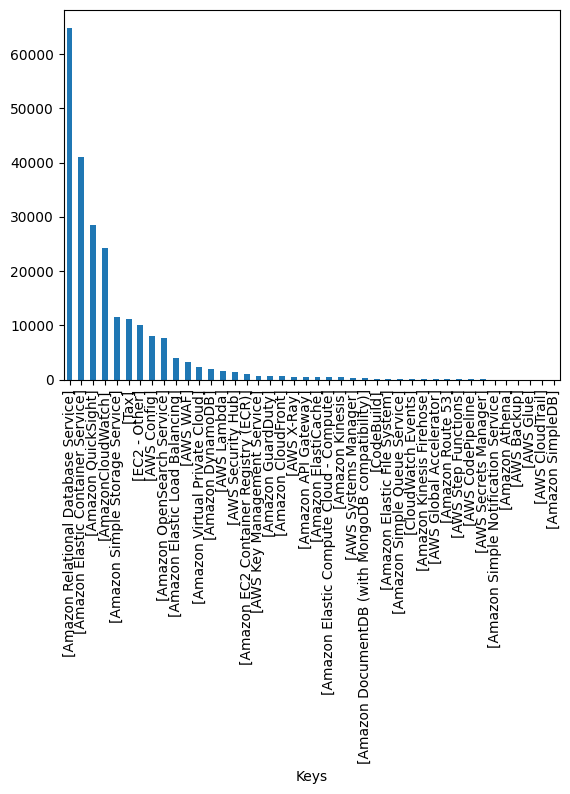

In [33]:
# Use the function with your profile to get a session
aws_session = set_aws_credentials('acl-production', 'eu-central-1')


def get_cost_and_usage_by_services(account_id, start, end):
    client = aws_session.client('ce')
    cu = []
    while True:
        data = client.get_cost_and_usage(
            TimePeriod={
                'Start': start,
                'End': end
            },
            Granularity='MONTHLY',
            Metrics=['BlendedCost'],
            GroupBy=[
                {
                    'Type': 'DIMENSION',
                    'Key': 'SERVICE',
                },
            ],
        )
        cu += data['ResultsByTime']
        token = data.get('NextPageToken')
        if not token:
            break

    return cu


result = get_cost_and_usage_by_services(accounts['ACL Production'], '2024-01-01', '2024-03-01')

# visualize result with Matplotlib
import matplotlib.pyplot as plt

df = pd.DataFrame(result[0]['Groups'])
df['Amount'] = df['Metrics'].apply(lambda x: x['BlendedCost']['Amount'])
df['Amount'] = df['Amount'].astype(float)
df = df.sort_values('Amount', ascending=False)
df = df.set_index('Keys')
df['Amount'].plot(kind='bar')
plt.show()
